In [39]:
import pandas as pd
import sqlite3
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# get spotify credentials
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
spotifyCred = pd.read_csv('spotifyCred.csv')

client_credentials_manager = SpotifyClientCredentials(client_id= spotifyCred['0'][0],
                                                     client_secret= spotifyCred['0'][1])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# conn = sqlite3.connect('/Users/aaronlevi/Documents/sql_db/chords_list.db')
conn = sqlite3.connect('/Users/aaronlevi/Documents/sql_db/pick-a-tune.db')
cur = conn.cursor()

In [16]:
# check if known-song & playlist is in db
track = 'weezer, island in the sun'
# track = 'jimi hendrix, all along the watchtower'

known_song   = str(track).split(', ')[1]
artist = str(track).split(', ')[0]
    
# get db...
song_info = pd.read_sql_query("SELECT * FROM basic_info", conn)
dblist    = song_info['Song'].tolist()
# song_info.drop('index', axis=1, inplace=True)
allFeatures = pd.read_sql_query("SELECT * FROM features", conn)    
# allFeatures.drop('index', axis=1, inplace=True)
isAdv = pd.read_sql_query("SELECT model_isAdv FROM label", conn) 

if known_song.replace(' ', '-').lower() in dblist:
    knownSong_ix = dblist.index(known_song.replace(' ', '-').lower())

    # get chords and features for the known song
    known_df = pd.DataFrame(song_info.loc[knownSong_ix]).transpose()
    known_df['isAdv'] = isAdv.loc[knownSong_ix][0]
    known_df['nChords'] = allFeatures['n_unique_chords'].loc[knownSong_ix]
    known_df['nDiffChords'] = allFeatures['n_difficult_chords'].loc[knownSong_ix]
    known_df['chordsPerMin'] = allFeatures['chord_per_min'].loc[knownSong_ix]

known_df.drop('index', axis=1, inplace=True)
known_df.reset_index(drop=True, inplace=True)
print(known_df)

                Song  Artist  \
0  island-in-the-sun  weezer   

                                          All Chords     Chords         Label  \
0  ['Em', 'Am', 'D', 'G', 'Em', 'Am', 'D', 'G', '...  Em,D,G,Am  intermediate   

                                                Link  isAdv  nChords  \
0  https://tabs.ultimate-guitar.com/tab/weezer/is...    0.0        4   

   nDiffChords  chordsPerMin  
0            0     30.852641  


In [4]:
# isAdv.to_csv('isAdv.csv', index=False)
# allFeatures.to_csv('allFeatures.csv', index=False)
# song_info.to_csv('song_info.csv', index=False)

In [5]:
# get playlist tracks
pl_link = 'https://open.spotify.com/playlist/37i9dQZF1DWXRqgorJj26U?si=Lls1MGwsQRKr4BN64HBRZw'
    
pl_id   = pl_link.split('playlist/')[1]
pl_id   = pl_id.split('?')[0]

pl_tracks  = []
pl_artists = []
pl_indb    = []

results = sp.user_playlist('Spotify', pl_id,
                            fields='tracks,next,name')

# check if their in the db
for nItem in range(0, len(results['tracks']['items'])):
    pl_tracks.append(results['tracks']['items'][nItem]['track']['name'].split(' -')[0].replace(' ', '-').lower() )
    #     pl_tracks.append(results['tracks']['items'][nItem]['track']['name'].replace(' ', '-').lower())
    pl_artists.append(results['tracks']['items'][nItem]['track']['artists'][0]['name'].replace(' ', '-').lower())

    if pl_tracks[nItem] in dblist:
        pl_indb.append(dblist.index(pl_tracks[nItem]))

#     return pl_tracks, pl_artists
# SELECT EXISTS(SELECT 1 FROM myTbl WHERE u_tag="tag");

# pl_db_ix = [i for i, x in enumerate(pl_indb) if x]

In [17]:
# get chords and features for playlist songs in db
input_df = song_info.loc[pl_indb]
input_df['isAdv'] = isAdv.loc[pl_indb]
input_df['nChords'] = allFeatures['n_unique_chords'].loc[pl_indb]
input_df['nDiffChords'] = allFeatures['n_difficult_chords'].loc[pl_indb]
input_df['chordsPerMin'] = allFeatures['chord_per_min'].loc[pl_indb]
    
input_df.drop('index', axis=1, inplace=True)
input_df.reset_index(drop=True, inplace=True)

input_df

,Song,Artist,All Chords,Chords,Label,Link,isAdv,nChords,nDiffChords,chordsPerMin
0,whole-lotta-love,led-zeppelin,"['D', 'E', 'E', 'D', 'E', 'E', 'D', 'E', 'D', ...","A,D,E",intermediate,https://tabs.ultimate-guitar.com/tab/led-zeppe...,0.0,3,0,16.891639
1,all-along-the-watchtower,bob-dylan,"['Am', 'G', 'F', 'G', 'Am', 'G', 'F', 'G', 'Am...","F,G,Am",intermediate,https://tabs.ultimate-guitar.com/tab/bob-dylan...,0.0,3,0,38.870432
2,come-together,the-beatles,"['Dm', 'Dm', 'A7', 'G7', 'Dm', 'Dm', 'A7', 'G7...","A,Dm,G7,Bm,G,A7",novice,https://tabs.ultimate-guitar.com/tab/the-beatl...,0.0,6,2,6.232040
3,should-i-stay-or-should-i-go,the-clash,"['D', 'F', 'G', 'A7', 'D5', 'F5', 'G5', 'A5', ...","G5,A5,D5,F5,D,G,A7,F",novice,https://tabs.ultimate-guitar.com/tab/the-clash...,1.0,8,5,38.732823
4,another-one-bites-the-dust,queen,"['Em', 'Am', 'Em', 'Am', 'C', 'G', 'C', 'G', '...","Em,A,C,Am,F#m,B,G",novice,https://tabs.ultimate-guitar.com/tab/queen/ano...,0.0,7,0,19.845984
5,light-my-fire,the-doors,"['G', 'D', 'F', 'Bb', 'Eb', 'Ab', 'A', 'A', 'A...","C,D7,Bb,Bm,D,G,Gm,Am,F#m,Eb,G#,Dsus4,A,B,Ab,E7...",intermediate,https://tabs.ultimate-guitar.com/tab/the-doors...,1.0,19,3,19.406180
6,american-girl,tom-petty-and-the-heartbreakers,"['D', 'E7', 'E7', 'G', 'G', 'A', 'A', 'D', 'D'...","Em,A,E7,G#,Bm,D,G,A7",novice,https://tabs.ultimate-guitar.com/tab/tom-petty...,0.0,8,2,23.750425
7,house-of-the-rising-sun,the-animals,"['Am', 'C', 'D', 'F', 'Am', 'E', 'Am', 'E', 'A...","C,Am,Dm,E,D,F",novice,https://tabs.ultimate-guitar.com/tab/the-anima...,0.0,6,0,36.493660
8,like-a-rolling-stone,bob-dylan,"['Fmaj7/C', 'Dm7', 'C', 'Fmaj7/C', 'C', 'Fmaj7...","Em,Dm7,C,Fmaj7/C,G,F",intermediate,https://tabs.ultimate-guitar.com/tab/bob-dylan...,0.0,6,2,30.844156
9,sunshine-of-your-love,cream,"['D', 'D', 'C', 'D', 'A', 'G#', 'G', 'D', 'F',...","A,C,G#,D,G,F",intermediate,https://tabs.ultimate-guitar.com/tab/cream/sun...,0.0,6,0,41.214058


In [27]:
# playing with similarity index across entire playlist
pl_simVec = input_df[['nChords', 'nDiffChords', 'chordsPerMin']]
ks_simVec = known_df[['nChords', 'nDiffChords', 'chordsPerMin']]

songDistance = []

for iSong in range(0, len(pl_simVec)):
    songDistance.append(np.linalg.norm(ks_simVec - pl_simVec.iloc[iSong]))
    
songDistance[23]
input_df.iloc[23]

Song                                                     paranoid
Artist                                              black-sabbath
All Chords      ['D', 'E', 'Em', 'D', 'G', 'D', 'Em', 'Em', 'D...
Chords                                                 Em,C,E,D,G
Label                                                intermediate
Link            https://tabs.ultimate-guitar.com/tab/black-sab...
isAdv                                                           0
nChords                                                         5
nDiffChords                                                     0
chordsPerMin                                              30.0288
Name: 23, dtype: object

In [7]:
# classify any songs not in db? 
# pd.read_sql_query("SELECT * FROM basic_info WHERE Song='island-in-the-sun'", conn)
# pd.read_sql_query("SELECT EXISTS(SELECT 1 FROM basic_info WHERE Song= str(pl_tracks[0]) ", conn)


In [51]:
# run chord similarity analysis of songs in same class
# known_df and input_df

# get index of playlist songs in same class
isAdvList = input_df['isAdv'].tolist()
targDifficulty = known_df['isAdv'][0]

if targDifficulty is 1:
    sameDiff = [i for i, x in enumerate(isAdvList) if x]
else:
    sameDiff = [i for i, x in enumerate(isAdvList) if not x]
    
# narrow to only sameDiff songs
sameDiff_df = input_df.loc[sameDiff]

# get a list of songs with the same or few n unique chords
close_n    = sameDiff_df['nChords'] <= known_df['nChords'][0]
close_n_ix = [i for i, x in enumerate(close_n) if x]

close_df = sameDiff_df.loc[close_n_ix]
close_df.reset_index(drop=True, inplace=True)

# measure similarity between song vectors using euclidean distance
close_simVec = close_df[['nChords', 'nDiffChords', 'chordsPerMin']]
songDistance = []
ks_simVec = known_df[['nChords', 'nDiffChords', 'chordsPerMin']]
for iSong in range(0, len(close_df)):
    songDistance.append(np.linalg.norm(ks_simVec - close_simVec.iloc[iSong]))

In [29]:
# if the known song is in the playlist, drop it from consideration
if known_df['Song'][0] in close_df['Song'].tolist():
    k_ix = close_df['Song'].tolist().index(known_df['Song'][0].replace(' ', '-').lower())

    # print(k_ix)
    # close_df
    close_df.drop(k_ix, axis=0, inplace=True)
    close_df.reset_index(drop=True, inplace=True)
    
    songDistance.drop(k_ix, axis=0, inplace=True)
    songDistance.reset_index(drop=True, inplace=True)

In [30]:

known_chords_list = known_df['Chords'][0].split(',')

close_nSameChords = []
close_propSameChords = []

far_nSameChords = []
far_propSameChords = []

for iSong in range(0, len(close_df)):
#     if isinstance(close_df['Chords'][iSong], str):
    close_nSameChords.append( len([ele for ele in known_chords_list if(ele in close_df['Chords'][iSong].split(','))]) )
    close_propSameChords.append( len([ele for ele in known_chords_list if(ele in close_df['Chords'][iSong].split(','))]) / len(close_df['Chords'][iSong].split(','))  )
#     else:
#         nSameChords.append(0)
#         propSameChords.append(0)

# for iSong in range(0, len(far_df)):
# #     if isinstance(close_df['Chords'][iSong], str):
#     far_nSameChords.append( len([ele for ele in known_chords_list if(ele in far_df['Chords'][iSong].split(','))]) )
#     far_propSameChords.append( len([ele for ele in known_chords_list if(ele in far_df['Chords'][iSong].split(','))]) / len(far_df['Chords'][iSong].split(','))  )
# #     else:
# #         nSameChords.append(0)
# #         propSameChords.append(0)
        
maxOverlap = np.argmax(close_propSameChords)
minOverlap = np.argmin(close_propSameChords)

# far_maxOverlap = np.argmax(far_propSameChords)
# far_minOverlap = np.argmin(far_propSameChords)


easy_rec   = close_df.iloc[maxOverlap]
medium_rec = close_df.iloc[minOverlap]
# hard_rec   = far_df.iloc[far_maxOverlap]
# wayhard_rec   = far_df.iloc[far_minOverlap]

print(easy_rec)
print(medium_rec)
# print(hard_rec)
# print(wayhard_rec)



Song                                     all-along-the-watchtower
Artist                                                  bob-dylan
All Chords      ['Am', 'G', 'F', 'G', 'Am', 'G', 'F', 'G', 'Am...
Chords                                                     F,G,Am
Label                                                intermediate
Link            https://tabs.ultimate-guitar.com/tab/bob-dylan...
isAdv                                                           0
nChords                                                         3
nDiffChords                                                     0
chordsPerMin                                              38.8704
Name: 1, dtype: object
Song                                        walk-on-the-wild-side
Artist                                                   lou-reed
All Chords      ['C', 'F', 'Dm', 'C', 'F', 'C', 'F', 'C', 'Dm'...
Chords                                                     Dm,C,F
Label                                                

In [11]:
easy_rec=pd.DataFrame(easy_rec).transpose()
easy_rec

,Song,Artist,All Chords,Chords,Label,Link,isAdv,nChords
1,all-along-the-watchtower,bob-dylan,"['Am', 'G', 'F', 'G', 'Am', 'G', 'F', 'G', 'Am...","F,G,Am",intermediate,https://tabs.ultimate-guitar.com/tab/bob-dylan...,0,3


[0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.42857142857142855, 0.0, 0.6]
[13.996770485904474, 8.079911365584637, 2.828439852850317, 20.29087803480176, 15.069857276285463, 1.2956448153740974]


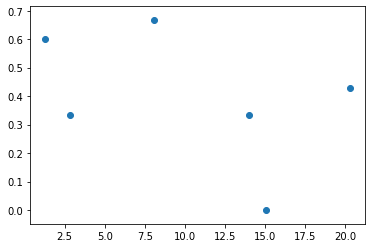

In [53]:
print(close_propSameChords)
print(songDistance)

plt.scatter(songDistance, close_propSameChords)

In [10]:
# # DO SAME FOR AN ADVANCED SONG
# get index of playlist songs in same class
isAdvList = input_df['isAdv'].tolist()
targDifficulty = 1

if targDifficulty is 1:
    sameDiff = [i for i, x in enumerate(isAdvList) if x]
else:
    sameDiff = [i for i, x in enumerate(isAdvList) if not x]

# narrow to only sameDiff songs
sameDiff_df = input_df.loc[sameDiff]

# # get a list of songs with the same or few n unique chords
# close_n    = sameDiff_df['nChords'] <= known_df['nChords'][0]
# close_n_ix = [i for i, x in enumerate(close_n) if x]

# close_df = sameDiff_df.loc[close_n_ix]
# close_df.reset_index(drop=True, inplace=True)

# # close_df = input_df.reindex[close_n_ix]

# close_df.reset_index(drop=True, inplace=True)

# known_chords_list = known_df['Chords'][0].split(',')

close_df = sameDiff_df
close_df.reset_index(drop=True, inplace=True)

nSameChords = []
propSameChords = []
cnt = 1

for iSong in range(0, len(close_df)):
    if isinstance(close_df['Chords'][iSong], str):
        nSameChords.append( len([ele for ele in known_chords_list if(ele in close_df['Chords'][iSong].split(','))]) )
        propSameChords.append( len([ele for ele in known_chords_list if(ele in close_df['Chords'][iSong].split(','))]) / len(close_df['Chords'][iSong].split(','))  )
    else:
        nSameChords.append(0)
        propSameChords.append(0)
        
maxOverlap = np.argmax(propSameChords)

hard_rec = close_df.iloc[maxOverlap]
print(hard_rec)

Song                                               american-pie
Artist                                               don-mclean
All Chords    ['G', 'D', 'Em', 'Am', 'C', 'Em', 'D', 'G', 'D...
Chords                                        G,A7,Am,Em,D7,D,C
Label                                              intermediate
isAdv                                                         1
nChords                                                       7
Name: 5, dtype: object


In [11]:
close_df['Chords']

0                                 G,G5,F5,A7,A5,F,D5,D
1    Gm,Em,F,E7,F#m,C,Ab,G#,Bb,D,Eb,Am,A,D7,G,Bm,Ds...
2    Am6,B7sus4,B7,Em7,G,B(b9),C#7,Am,A,B5,Cmaj7,B,...
3    Db7,Bdim7,Bb7,Abm,F7,Gm,Dm/C#,Abdim,Db/Bb,F,E7...
4                      C,C#m7,Dm,A,E7,B,E,Bb,F#m,D,G#7
5                                    G,A7,Am,Em,D7,D,C
6                             G,G5,F5,A,C5,A5,F,D5,D,C
7     G,Asus4,Am,Dm7,Cadd9,Cmaj7,G/B,D/F#,Am/G,C,Asus2
8       Csus2/F,C/G,Cm/F,C5/G,F7,C7/G,Fsus2,Am/G,Cm6/G
Name: Chords, dtype: object

In [10]:
known_df['Chords'][0]

'G,Am,F'

In [ ]:
easy_rec['Song'].replace('-', ' ').title()

In [312]:
easy_rec['Artist'].replace('-', ' ').title()

'Stevie Nicks'

In [311]:
medium_rec['Song'].replace('-', ' ').title()

'All Along The Watchtower'

In [288]:
medium_rec['Artist'].replace('-', ' ').title()

'Jimi Hendrix'